# 1. Importación de librerías y carga de datos

In [1]:
# Ni escalado ni estandarizado
SCALED=False
STANDARIZED=False

In [2]:
# Importamos las librerías necesarias

import haversine as hs
import pandas as pd
import numpy as np
import pickle
import time
import os

import tensorflow as tf
tf.config.run_functions_eagerly(True)
from keras.models import Sequential
from keras.optimizers import Adam, SGD
from keras.layers import LSTM, GRU, Dense, Reshape, Dropout, Bidirectional, \
  RepeatVector, TimeDistributed, Conv1D, MaxPooling1D, Flatten, ConvLSTM2D
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from haversine import inverse_haversine, Direction
from attention import Attention

if SCALED:
    from sklearn.preprocessing import MinMaxScaler
elif STANDARIZED:
    from sklearn.preprocessing import StandardScaler

from shapely import geometry
import geopy
import geopy.distance
import math

import matplotlib.pyplot as plt

from codecarbon import EmissionsTracker

C:\Users\sandr\anaconda3\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [3]:
# Hacemos el resultado reproducible
from numpy.random import seed
seed(1)
tf.random.set_seed(2)

# Declaramos el tipo de float, en este caso float64
tf.keras.backend.set_floatx('float64')

In [4]:
# Leemos y guardamos la info de segudo y vehículo
df = pd.read_csv('positions.csv')

columns = ['time(s)', 'vehicle_id']
df = df[columns]
df = df.sort_values(by=['vehicle_id', 'time(s)'])
df.head()

C:\Users\sandr\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,time(s),vehicle_id
0,1.0,0
31,2.0,0
64,3.0,0
100,4.0,0
158,5.0,0


In [19]:
df_data = pd.read_csv('positions.csv')
df_data = df_data.sort_values(by=['vehicle_id', 'time(s)'])
df_data.head()

,time(s),vehicle_id,victim_id,shape_collider,shape_victim,latitude(m),longitude(m),speed(m/s),heading,acceleration(m/s²),collision
0,1.0,0,-1,passenger,-1,41.402717,2.137950,14.723400,137.798227,0.000000,0
31,2.0,0,-1,passenger,-1,41.402633,2.138082,14.418443,128.510085,-0.304957,0
64,3.0,0,-1,passenger,-1,41.402549,2.138213,14.193703,128.510085,-0.224740,0
100,4.0,0,-1,passenger,-1,41.402468,2.138340,13.853303,135.176752,-0.340400,0
158,5.0,0,-1,passenger,-1,41.402378,2.138462,14.350286,135.176752,0.496983,0


In [5]:
# Load MinMaxScaler for target variables
if SCALED:
    MINMAXSCALER_FILE = './minmaxscaler.pkl'#os.path.join("TFM", "implementation",
                             #"data_preparation", "minmaxscaler.pkl")
    with open(MINMAXSCALER_FILE, 'rb') as f_minmaxscaler:
        minmaxscaler = pickle.load(f_minmaxscaler)
if STANDARIZED:
    TARGETS_STAND_FILE = './' #os.path.join("TFM", "implementation",
                                     #"data_preparation", "targets_stand.pkl")
    with open(TARGETS_STAND_FILE, 'rb') as f_scaler:
        standscaler_targets = pickle.load(f_scaler)

In [6]:
# Load training dataset
if SCALED:
    DATASET_TRAIN = os.path.join('./',
                               "ventanas_no_coincidentes_train_val_scaled.npz")
elif STANDARIZED:
    DATASET_TRAIN = os.path.join('./',
                               "ventanas_no_coincidentes_train_val_stand.npz")
else:
    DATASET_TRAIN = os.path.join('./',
                               "ventanas_no_coincidentes_train_val.npz")
    
npzfile = np.load(DATASET_TRAIN)
X_train = npzfile['X_train']
X_val = npzfile['X_val']
y_train = npzfile['y_train']
y_val = npzfile['y_val']
print("X_train: {}  y_train: {}\nX_val: {}  y_val: {}"
      .format(X_train.shape, y_train.shape, X_val.shape, y_val.shape))

# Load testing dataset
if SCALED:
    DATASET_TEST = os.path.join('./',
                              "ventanas_no_coincidentes_test_scaled.npz")
elif STANDARIZED:
    DATASET_TEST = os.path.join('./',
                              "ventanas_no_coincidentes_test_stand.npz")
else:
    DATASET_TEST = os.path.join('./',
                              "ventanas_no_coincidentes_test.npz")
npzfile = np.load(DATASET_TEST)
X_test = npzfile['X_test']
y_test = npzfile['y_test']
print("X_test: {}  y_test: {}".format(X_test.shape, y_test.shape))

# Load testing vehicle ids list
VEHICLE_IDS_FILE = os.path.join('./', "vehicle_ids.pkl")
with open(VEHICLE_IDS_FILE, 'rb') as f_vehicle_ids:
    vehicle_ids = pickle.load(f_vehicle_ids)
print("Vehicle_ids: {}".format(len(vehicle_ids)))

X_train: (6005877, 20, 5)  y_train: (6005877, 5, 5)
X_val: (2573948, 20, 5)  y_val: (2573948, 5, 5)
X_test: (2402, 20, 5)  y_test: (2402, 5, 5)
Vehicle_ids: 8972


In [7]:
# Load dataset with vehicles dimensions
DATASET_DIM = os.path.join('./', "dimensions.csv")
df_dim = pd.read_csv(DATASET_DIM)
df_dim = df_dim[['vehicle_id', 'length', 'width']]
df_dim.head()

,vehicle_id,length,width
0,0,5.0,1.8
1,2,5.0,1.8
2,3,5.0,1.8
3,4,2.2,0.9
4,5,5.0,1.8


In [8]:
# Load dataset with vehicles colision
#DATASET_COL = os.path.join('./', "collisions_1k.csv")
df_col = pd.read_csv('collisions_2k.csv')
df_col = df_col[['vehicle_id', 'victim_id']].astype(int)
df_col.head()

,vehicle_id,victim_id
0,1240,5722
1,209,802
2,863,300
3,6444,3528
4,798,2787


In [9]:
# Load dataset with vehicles no-colision
#DATASET_NOCOL = os.path.join('./', "no_collisions_1k.csv")
df_nocol = pd.read_csv('no_collisions_2k.csv')
df_nocol = df_nocol[['v1', 'v2']]
df_nocol.head()

,v1,v2
0,31477,34003
1,33063,33228
2,33130,33973
3,33268,33958
4,33268,34256


In [10]:
df_col.shape

(2120, 2)

In [11]:
df_nocol.shape

(2120, 2)

# 2. Generación y entrenamiento de los modelos

In [13]:
#if SCALED:
#    MODELS_FOLDER = os.path.join("TFM", "implementation", "models", "scaled")
#elif STANDARIZED:
#    MODELS_FOLDER = os.path.join("TFM", "implementation", "models", "standarized")
#else:
#    MODELS_FOLDER = os.path.join("TFM", "implementation", "models", "real")
    
MODELS_FOLDER = './'

In [15]:
# Windows parameters
INPUT_WIDTH=20
OUTPUT_WIDTH=5
OFFSET_WIDTH=0

# Input and output columns
INPUT_COL = ['latitude(m)', 'longitude(m)', 'heading', 'speed(m/s)', 'acceleration(m/s²)']
OUTPUT_COL = ['latitude(m)', 'longitude(m)', 'heading', 'speed(m/s)', 'acceleration(m/s²)']

# Training parameters
EPOCHS= 2
BATCH_SIZE=64
PATIENCE=5
REDUCELR=0.2

# Define loss function
def physics_loss(y_true, y_pred):

    # Para facilitar el cálculo, hacemos un reshape de y_true para juntar las 64 muestras (batch_size)
    a,b,c = tf.shape(y_true)
    y_true = tf.reshape(y_true, [a.numpy()*b.numpy(),c.numpy()])
    y_pred = tf.reshape(y_pred, [a.numpy()*b.numpy(),c.numpy()])
    
    
    # Calculamos velocidades y aceleraciones
    vx = tf.gather(y_true,[3],axis=1) * tf.math.cos(tf.gather(y_true,[2],axis=1))
    vy = tf.gather(y_true,[3],axis=1) * tf.math.sin(tf.gather(y_true,[2],axis=1))
    ax = tf.gather(y_true,[4],axis=1) * tf.math.cos(tf.gather(y_true,[2],axis=1))
    ay = tf.gather(y_true,[4],axis=1) * tf.math.sin(tf.gather(y_true,[2],axis=1))

    # Aplicamos las ecuaciones del movimiento para obtener la distancia recorrida en metros
    dist_lat_m = vy + ay/2
    dist_lon_m = vx + ax/2

    # Pasamos la distancia recorrida en metros a las distancias en latitud longitud
    dist_lat = (dist_lat_m/6371000)*(180/math.pi)
    dist_lon = (dist_lon_m/6371000)*(180/math.pi) / tf.math.cos(tf.gather(y_true,[0],axis=1) * math.pi/180)

    # Calculamos las nuevas latitud y longitud
    pred_latitude = tf.gather(y_true,[0],axis=1) + dist_lat
    pred_longitude = tf.gather(y_true,[1],axis=1) + dist_lon
    
    # La pérdida será reducir la distancia entre las predichas y las calculadas físicamente
    loss = tf.reduce_mean(tf.square(pred_latitude -tf.gather(y_pred,[0],axis=1)) 
                          + tf.square(pred_longitude -tf.gather(y_pred,[1],axis=1)))
    
    
    return loss

def compile_and_fit(model, X_train, y_train, X_val, y_val, folder, epochs=20,
                    batch_size=32, patience=2, learning_rate=0.001, reduce_lr=0):
    tracker = EmissionsTracker(log_level="error")
    callback_list = []

    # Return best model that minimize loss function
    early_stopping = EarlyStopping(
        monitor='val_loss', patience=patience*2, mode='min',
        restore_best_weights=True)
    callback_list.append(early_stopping)

    # Save best model that minimize loss function
    checkpoint_file = os.path.join(folder, 'model_saved.hdf5')
    checkpoint = ModelCheckpoint(
        filepath=checkpoint_file, monitor='val_loss', mode="min",
        save_best_only=True, verbose=0)
    callback_list.append(checkpoint)
  
    if reduce_lr != 0:
        # Reduce learning rate to minimize loss function
        reduce_learningrate = ReduceLROnPlateau(
            monitor='val_loss', patience=patience, mode='min', factor=reduce_lr)
        callback_list.append(reduce_learningrate)

    model.compile(loss=physics_loss,#tf.keras.losses.MeanSquaredError(),
                  optimizer=Adam(learning_rate=learning_rate),
                  metrics=[tf.keras.metrics.MeanAbsoluteError()])

    tracker.start()
    start_time = time.time()
    print('X_train.shape:', X_train.shape)
    print('y_train.shape:', y_train.shape)
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                      validation_data=(X_val, y_val),
                      callbacks=callback_list)
    total_time = time.time() - start_time
    emissions = tracker.stop()

    # Save fit history
    history_pickle = os.path.join(folder, 'history.pkl')
    pickle.dump(history.history, open(history_pickle, 'wb'))

    # Print and write fit statistics
    min_val_loss = min(history.history['val_loss'])
    best_model_index = history.history['val_loss'].index(min_val_loss)
    print("\nTraining Loss (MSE): {}".format(history.history['loss'][best_model_index]))
    print("Validation Loss (MSE): {}".format(history.history['val_loss'][best_model_index]))
    print("Training MAE: {}".format(history.history['mean_absolute_error'][best_model_index]))
    print("Validation MAE: {}".format(history.history['val_mean_absolute_error'][best_model_index]))
    print("Execution time (s): {}".format(total_time))
    print("Emissions (kg): {}\n".format(emissions))
    stats_file = os.path.join(folder, "stats.txt")
    with open(stats_file, 'w') as f_stats:
        f_stats.write("Training Loss (MSE): {}\n".format(history.history['loss'][best_model_index]))
        f_stats.write("Validation Loss (MSE): {}\n".format(history.history['val_loss'][best_model_index]))
        f_stats.write("Training MAE: {}\n".format(history.history['mean_absolute_error'][best_model_index]))
        f_stats.write("Validation MAE: {}\n".format(history.history['val_mean_absolute_error'][best_model_index]))
        f_stats.write("Execution time (s): {}\n".format(total_time))
        f_stats.write("Emissions (kg): {}\n".format(emissions))

    return history


def plot_history(history, start=None, end=None):
    train_loss = history['loss'][start:end]
    val_loss = history['val_loss'][start:end]
    train_mae = history['mean_absolute_error'][start:end]
    test_mae = history['val_mean_absolute_error'][start:end]

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    ax[0].plot(train_loss, label="Train")
    ax[0].plot(val_loss, label="Validation")
    ax[0].set_title("Training and Validation loss")
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Loss")
    ax[0].legend()

    ax[1].plot(train_mae, label="Train")
    ax[1].plot(test_mae, label="Validation")
    ax[1].set_title("Training and Validation MAE")
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Mean Absolute Error")
    ax[1].legend()

    plt.show()


def model_predictions(model, X_test, y_test):
    def calculate_haversine(coord1, coord2):
        return hs.haversine(coord1, coord2, unit=hs.Unit.METERS)

    y_pred = model.predict(X_test)
    if SCALED:
        y_pred = minmaxscaler.inverse_transform(y_pred.reshape(-1, 2))
    elif STANDARIZED:
        y_pred = standscaler_targets.inverse_transform(y_pred.reshape(-1, 2))
    y_pred = y_pred.reshape(-1, 5)

    if SCALED:
        y_test = minmaxscaler.inverse_transform(y_test.reshape(-1, 2))
    elif STANDARIZED:
        y_test = standscaler_targets.inverse_transform(y_test.reshape(-1, 2))
    y_test = y_test.reshape(-1, 5)

    df_y_pred = pd.DataFrame(
        y_pred, columns=['latitude(pred)', 'longitude(pred)','heading(pred)', 'speed(m/s)(pred)', 'acceleration(m/s²)(pred)'])
    df_y_test = pd.DataFrame(y_test, columns=['latitude', 'longitude', 'heading', 'speed(m/s)', 'acceleration(m/s²)'])
    df_pred = pd.concat([df_y_pred, df_y_test], axis=1)

    distance = df_pred.apply(
        lambda row: calculate_haversine((row['latitude(pred)'], row['longitude(pred)']),
                                        (row['latitude'], row['longitude'])), axis=1)
    df_pred['distance(m)'] = distance

    return df_pred

In [59]:
import warnings
warnings.filterwarnings('ignore')

def bearing_calc(a_lat, a_lon, b_lat, b_lon): # a previous position b current position
    rlat1 = math.radians(a_lat)
    rlon1 = math.radians(a_lon)
    rlat2 = math.radians(b_lat)
    rlon2 = math.radians(b_lon)
    dlon = math.radians(b_lon - a_lon)
    b = math.atan2(
      math.sin(dlon)*math.cos(rlat2),
      math.cos(rlat1)*math.sin(rlat2)-math.sin(rlat1)*math.cos(rlat2)*math.cos(dlon))  # bearing calc
    bd = math.degrees(b)
    br, bn = divmod(bd + 360, 360)  # the bearing remainder and final bearing
    return bn


# To get a rotated rectangle at a bearing, you need to get the points of the the recatangle at that bearing
def get_rotated_points(coordinates, bearing, width, length):
    start = geopy.Point(coordinates)
    width = width/1000
    length = length/1000
    rectlength = geopy.distance.distance(kilometers=length)
    rectwidth = geopy.distance.distance(kilometers=width)
    halfwidth = geopy.distance.distance(kilometers=width/2)
    halflength = geopy.distance.distance(kilometers=length/2)

    pointAB = halflength.destination(point=start, bearing=bearing)
    pointA = halfwidth.destination(point=pointAB, bearing=0 - bearing)
    pointB = rectwidth.destination(point=pointA, bearing=180 - bearing)
    pointC = rectlength.destination(point=pointB, bearing=bearing - 180)
    pointD = rectwidth.destination(point=pointC, bearing=0 - bearing)

    points = []
    for point in [pointA, pointB, pointC, pointD]:
        coords = (point.latitude, point.longitude)
        points.append(coords)

    return points

def get_colision(v1_id, v2_id, X_test_v1, X_test_v2, dimensions, model):
    colision = 0

    y_pred_v1 = model.predict(X_test_v1.reshape(1, 20, 5), verbose=0)
    if SCALED:
        y_pred_v1 = minmaxscaler.inverse_transform(y_pred_v1.reshape(-1, 2))
    elif STANDARIZED:
        y_pred_v1 = standscaler_targets.inverse_transform(y_pred_v1.reshape(-1, 2))
    y_pred_v1 = y_pred_v1.reshape(-1, 5)
    v1_coord_5 = y_pred_v1[-1]

    v1_length = dimensions[dimensions['vehicle_id'] == v1_id].iloc[0, 1]
    v1_width = dimensions[dimensions['vehicle_id'] == v1_id].iloc[0, 2]

    v1_points = get_rotated_points(tuple(v1_coord_5[:2]), v1_coord_5[-1],
                                 v1_width, v1_length)
    polygon1 = geometry.Polygon(v1_points)

    y_pred_v2 = model.predict(X_test_v2.reshape(1, 20, 5), verbose=0)
    if SCALED:
        y_pred_v2 = minmaxscaler.inverse_transform(y_pred_v2.reshape(-1, 5))
    elif STANDARIZED:
        y_pred_v2 = standscaler_targets.inverse_transform(y_pred_v2.reshape(-1, 2))
    y_pred_v2 = y_pred_v2.reshape(-1, 5)
    v2_coord_5 = y_pred_v2[-1]

    v2_length = dimensions[dimensions['vehicle_id'] == v2_id].iloc[0, 1]
    v2_width = dimensions[dimensions['vehicle_id'] == v2_id].iloc[0, 2]

    v2_points = get_rotated_points(tuple(v2_coord_5[:2]), v2_coord_5[-1],
                                 v2_width, v2_length)
    polygon2 = geometry.Polygon(v2_points)

    if polygon1.intersection(polygon2).area > 0.0:
        colision = 1
  
    return colision

def get_metrics(model, X_test, df, vehicle_ids, df_col, df_nocol, df_dim,
                metrics_file):
    total_colision = 0
    total_no_colision = 0

    true_positive = 0
    false_negative = 0
    false_positive = 0
    true_negative = 0

    # Vehiculos que coinciden y colisionan
    print('coinciden y colisionan:', df_col.shape[0])
    i = 0
    while (true_positive + false_negative) < 1200 and i < df_col.shape[0]:
    #for i in range(df_col.shape[0]):
        if i%100 == 0:
            print(i)
        v1_id = df_col.iloc[i, 0]
        v2_id = df_col.iloc[i, 1]

        v1_ts_set = set(df[df['vehicle_id'] == v1_id].iloc[-5:, 0])
        v2_ts_set = set(df[df['vehicle_id'] == v2_id].iloc[-5:, 0])
        intersection = sorted(list(v1_ts_set.intersection(v2_ts_set)))
        if len(intersection) >= 2:
            total_colision += 1
            #v1_index = vehicle_ids.index(v1_id)
            #v2_index = vehicle_ids.index(v2_id)
            
            # Cogemos los 20 segundos antes de la intersección
            X_v1 = df_data.loc[(df_data['vehicle_id'] == v1_id) & 
                               (df_data['time(s)'].isin(range(int(min(v1_ts_set))-20, int(min(v1_ts_set))))),
                              INPUT_COL].values.tolist()
            X_v2 = df_data.loc[(df_data['vehicle_id'] == v2_id) & 
                               (df_data['time(s)'].isin(range(int(min(v2_ts_set))-20, int(min(v2_ts_set))))),
                              INPUT_COL].values.tolist()
            #if get_colision(v1_id, v2_id, X_test[v1_index], X_test[v2_index], df_dim, model):
            if len(X_v1) == 20 and len(X_v2) == 20 and get_colision(v1_id, v2_id, np.array(X_v1), np.array(X_v2), df_dim, model):
                true_positive += 1
            else:
                false_negative += 1
        i = i+1
            

    # Vehiculos que coinciden pero no colisionan
    print('coinciden pero no colisionan:', df_nocol.shape[0])
    i = 0
    while (false_positive + true_negative) < 1200 and i < df_nocol.shape[0]:
    #for i in range(df_nocol.shape[0]):
        if i%100 == 0:
            print(i)
        v1_id = df_nocol.iloc[i, 0]
        v2_id = df_nocol.iloc[i, 1]

        v1_ts_set = set(df[df['vehicle_id'] == v1_id].iloc[-5:, 0])
        v2_ts_set = set(df[df['vehicle_id'] == v2_id].iloc[-5:, 0])
        intersection = sorted(list(v1_ts_set.intersection(v2_ts_set)))
        if len(intersection) >= 2:
            total_no_colision += 1 
            #v1_index = vehicle_ids.index(v1_id)
            #v2_index = vehicle_ids.index(v2_id)
            
            # Cogemos los 20 segundos antes de la intersección
            X_v1 = df_data.loc[(df_data['vehicle_id'] == v1_id) & 
                               (df_data['time(s)'].isin(range(int(min(v1_ts_set))-20, int(min(v1_ts_set))))),
                              INPUT_COL].values.tolist()
            X_v2 = df_data.loc[(df_data['vehicle_id'] == v2_id) & 
                               (df_data['time(s)'].isin(range(int(min(v2_ts_set))-20, int(min(v2_ts_set))))),
                              INPUT_COL].values.tolist()
            
            #if get_colision(v1_id, v2_id, X_test[v1_index], X_test[v2_index], df_dim, model):
            if len(X_v1) == 20 and len(X_v2) == 20 and get_colision(v1_id, v2_id, np.array(X_v1), np.array(X_v2), df_dim, model):
                false_positive += 1
            else:
                true_negative += 1
        i = i+1

    print('false_positive:', false_positive)
    print('true_negative:', true_negative)
    accuracy = (true_positive+true_negative)/(true_positive+false_positive+false_negative+true_negative)
    precision = true_positive/(true_positive+false_positive) if (true_positive+false_positive) != 0 else 0
    recall = true_positive/(true_positive+false_negative) if (true_positive+false_negative) != 0 else 0
    F1_score = 2*(recall*precision)/(recall+precision) if (recall+precision) != 0 else 0
    specificity = true_negative/(true_negative+false_positive) if (true_negative+false_positive) != 0 else 0

    with open(metrics_file, 'w') as f_metrics:
        f_metrics.write("Total colision: {}\n".format(total_colision))
        f_metrics.write("TP: {}\n".format(true_positive))
        f_metrics.write("FN: {}\n".format(false_negative))
        f_metrics.write("Total no colision: {}\n".format(total_no_colision))
        f_metrics.write("FP: {}\n".format(false_positive))
        f_metrics.write("TN: {}\n\n".format(true_negative))
        f_metrics.write("Accuracy: {}\n".format(accuracy))
        f_metrics.write("Precision: {}\n".format(precision))
        f_metrics.write("Recall: {}\n".format(recall))
        f_metrics.write("F1 Score: {}\n".format(F1_score))
        f_metrics.write("Specificity: {}\n".format(specificity))


    print("Total colision: {}".format(total_colision))
    print("TP: {}".format(true_positive))
    print("FN: {}".format(false_negative))
    print("Total no colision: {}".format(total_no_colision))
    print("FP: {}".format(false_positive))
    print("TN: {}".format(true_negative))
    print()
    print("Accuracy: {}".format(accuracy))
    print("Precision: {}".format(precision))
    print("Recall: {}".format(recall))
    print("F1 Score: {}".format(F1_score))
    print("Specificity: {}".format(specificity))

## 2.1. PINNs

In [15]:
def make_lstm_model(units, in_steps, out_steps, in_features, out_features):
    lstm_model = Sequential()

    # Shape [batch, time, in_features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    lstm_model.add(LSTM(
      units, input_shape=(in_steps, in_features)))

    # Shape => [batch, out_steps*out_features].
    lstm_model.add(Dense(out_steps*out_features))

    # Shape => [batch, out_steps, out_features].
    lstm_model.add(Reshape([out_steps, out_features]))

    lstm_model.summary()

    return lstm_model

### 2.1.1. Modelo LSTM (64 unidades)

#### 2.1.1.1. Creación y entrenamiento de la red

In [16]:
# Create model folder
MODEL_FOLDER = os.path.join(MODELS_FOLDER, "simple_v2", "PINN_LSTM_64units")
os.makedirs(MODEL_FOLDER, exist_ok=True)

# Model parameters
LSTM_UNITS=64

# Create, compile and fit model
lstm_model = make_lstm_model(LSTM_UNITS, INPUT_WIDTH, OUTPUT_WIDTH,
                             len(INPUT_COL), len(OUTPUT_COL))
history = compile_and_fit(lstm_model, X_train, y_train, X_val, y_val,
                          MODEL_FOLDER, epochs=EPOCHS, batch_size=BATCH_SIZE,
                          patience=PATIENCE, reduce_lr=REDUCELR)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                17920     
                                                                 
 dense (Dense)               (None, 25)                1625      
                                                                 
 reshape (Reshape)           (None, 5, 5)              0         
                                                                 
Total params: 19,545
Trainable params: 19,545
Non-trainable params: 0
_________________________________________________________________
X_train.shape: (6005877, 20, 5)
y_train.shape: (6005877, 5, 5)
Epoch 1/2
93842/93842 [==============================] - 10562s 113ms/step - loss: 3.8777 - mean_absolute_error: 36.1537 - val_loss: 1.8212e-05 - val_mean_absolute_error: 36.1129 - lr: 0.0010
Epoch 2/2
93842/93842 [==============================] - 1137

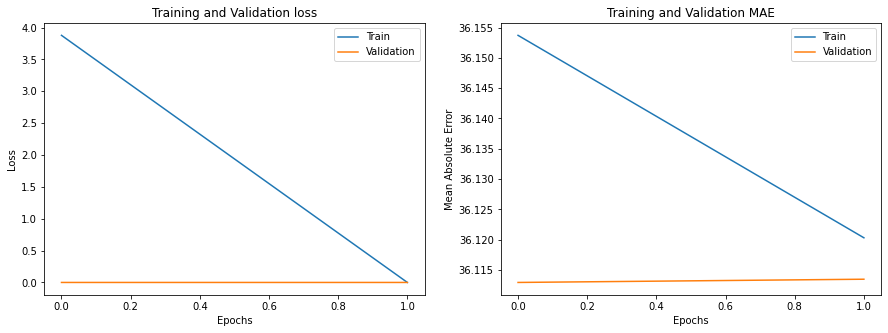

In [17]:
plot_history(history.history)

#### 2.1.1.2. Predicción de la red

In [18]:
df_pred = model_predictions(lstm_model, X_test, y_test)
print("Distance(m): [{}, {}]".format(min(df_pred['distance(m)']),
                                     max(df_pred['distance(m)'])))
df_pred

76/76 [==============================] - 2s 26ms/step
Distance(m): [19.95771821219744, 1394.648211866923]


,latitude(pred),longitude(pred),heading(pred),speed(m/s)(pred),acceleration(m/s²)(pred),latitude,longitude,heading,speed(m/s),acceleration(m/s²),distance(m)
0,41.397425,2.156562,1.585576,-0.691889,-1.015169,41.394340,2.151350,72.348077,0.000000,0.000000,553.808878
1,41.397384,2.156638,-1.980503,0.134884,0.265366,41.394340,2.151350,72.348077,0.000000,0.000000,555.960189
2,41.397346,2.156575,0.533328,0.085629,-0.470730,41.394340,2.151350,72.348077,0.000000,0.000000,549.219690
3,41.397341,2.156585,0.567162,0.395341,0.276055,41.394340,2.151350,72.348077,0.000000,0.000000,549.592092
4,41.397240,2.156601,-0.162527,1.951787,-0.283960,41.394340,2.151350,72.348077,0.000000,0.000000,543.922738
...,...,...,...,...,...,...,...,...,...,...,...
12005,41.400936,2.152462,1.584013,-0.691827,-1.017311,41.400268,2.151179,44.652289,7.775367,0.289365,130.231382
12006,41.400966,2.152441,-1.977534,0.130810,0.261673,41.400317,2.151234,39.488036,7.149873,-0.625495,123.869331
12007,41.400931,2.152449,0.533445,0.082574,-0.471731,41.400383,2.151277,23.947936,8.208109,1.058236,115.197110
12008,41.400872,2.152486,0.566697,0.394104,0.273079,41.400452,2.151264,348.255669,8.071555,-0.136553,112.142103


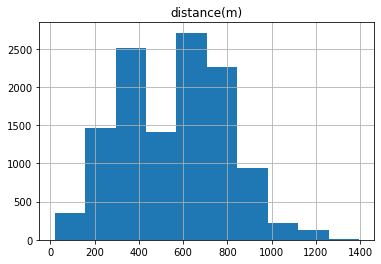

In [19]:
df_pred.hist('distance(m)')
plt.show()

In [20]:
n_rows = df_pred.shape[0]
list_1seg, list_2seg, list_3seg, list_4seg, list_5seg = \
  [False]*n_rows, [False]*n_rows, [False]*n_rows, [False]*n_rows, [False]*n_rows

for i in range(n_rows):
    if i%5 == 0:
        list_1seg[i] = True
    elif i%5 == 1:
        list_2seg[i] = True
    elif i%5 == 2:
        list_3seg[i] = True
    elif i%5 == 3:
        list_4seg[i] = True
    elif i%5 == 4:
        list_5seg[i] = True

df_pred_1seg = df_pred.iloc[list_1seg, :]
df_pred_2seg = df_pred.iloc[list_2seg, :]
df_pred_3seg = df_pred.iloc[list_3seg, :]
df_pred_4seg = df_pred.iloc[list_4seg, :]
df_pred_5seg = df_pred.iloc[list_5seg, :]

In [21]:
print("Segundo 1: [{}, {}]".format(min(df_pred_1seg['distance(m)']),
                                   max(df_pred_1seg['distance(m)'])))
print("Segundo 2: [{}, {}]".format(min(df_pred_2seg['distance(m)']),
                                   max(df_pred_2seg['distance(m)'])))
print("Segundo 3: [{}, {}]".format(min(df_pred_3seg['distance(m)']),
                                   max(df_pred_3seg['distance(m)'])))
print("Segundo 4: [{}, {}]".format(min(df_pred_4seg['distance(m)']),
                                   max(df_pred_4seg['distance(m)'])))
print("Segundo 5: [{}, {}]".format(min(df_pred_5seg['distance(m)']),
                                   max(df_pred_5seg['distance(m)'])))

Segundo 1: [32.45063828998175, 1349.5164313984942]
Segundo 2: [24.110240585531557, 1364.5413511493605]
Segundo 3: [26.48301792916798, 1369.4709564367877]
Segundo 4: [23.193323633342676, 1381.734955889055]
Segundo 5: [19.95771821219744, 1394.648211866923]


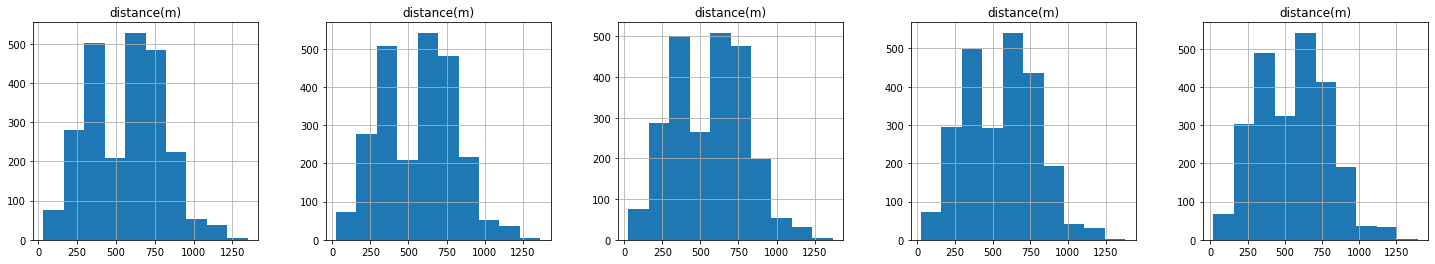

In [22]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(25,4))
df_pred_1seg.hist('distance(m)', ax=ax[0])
df_pred_2seg.hist('distance(m)', ax=ax[1])
df_pred_3seg.hist('distance(m)', ax=ax[2])
df_pred_4seg.hist('distance(m)', ax=ax[3])
df_pred_5seg.hist('distance(m)', ax=ax[4])
plt.show()

In [23]:
df_pred_1seg.describe()

,latitude(pred),longitude(pred),heading(pred),speed(m/s)(pred),acceleration(m/s²)(pred),latitude,longitude,heading,speed(m/s),acceleration(m/s²),distance(m)
count,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000
mean,41.399694,2.153870,1.584174,-0.692256,-1.016357,41.396994,2.149619,184.171392,5.743007,0.164075,557.642209
std,0.001035,0.001710,0.001629,0.001249,0.000618,0.002307,0.003671,98.232361,5.102721,1.308594,238.086950
min,41.394026,2.148685,1.580529,-0.695015,-1.018357,41.390906,2.139125,0.939814,0.000000,-10.000000,32.450638
25%,41.398813,2.152183,1.582661,-0.693531,-1.016762,41.395245,2.147242,101.919406,0.172846,-0.104516,343.023570
50%,41.399601,2.154233,1.585240,-0.691597,-1.016235,41.396960,2.149929,155.247244,4.966377,0.000000,584.790533
75%,41.400528,2.155580,1.585620,-0.691319,-1.016001,41.398961,2.151950,256.275266,10.340684,0.774525,726.381865
max,41.402168,2.157129,1.586992,-0.690478,-1.014260,41.401814,2.158624,357.404922,16.640354,5.988961,1349.516431


In [24]:
df_pred_2seg.describe()

,latitude(pred),longitude(pred),heading(pred),speed(m/s)(pred),acceleration(m/s²)(pred),latitude,longitude,heading,speed(m/s),acceleration(m/s²),distance(m)
count,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000
mean,41.399692,2.153885,-1.978513,0.132443,0.263196,41.396996,2.149621,184.160835,5.890808,0.147801,557.802166
std,0.001041,0.001711,0.001242,0.001227,0.001036,0.002308,0.003673,98.298534,4.947635,1.448525,238.314774
min,41.393437,2.148981,-1.980757,0.129261,0.260448,41.390873,2.139078,0.939814,0.000000,-10.000000,24.110241
25%,41.398818,2.152209,-1.979728,0.131719,0.262701,41.395234,2.147314,101.844412,0.968818,-0.154634,344.682696
50%,41.399582,2.154328,-1.978939,0.132203,0.263112,41.396960,2.149913,155.264593,5.239587,0.030756,583.299370
75%,41.400516,2.155586,-1.977238,0.133503,0.264002,41.398949,2.151951,256.443895,9.990617,0.898349,729.368642
max,41.402196,2.157169,-1.975447,0.135642,0.266129,41.401864,2.158743,358.402101,16.602367,5.993102,1364.541351


In [25]:
df_pred_3seg.describe()

,latitude(pred),longitude(pred),heading(pred),speed(m/s)(pred),acceleration(m/s²)(pred),latitude,longitude,heading,speed(m/s),acceleration(m/s²),distance(m)
count,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000
mean,41.399636,2.153853,0.534029,0.083465,-0.471205,41.396996,2.149623,184.186244,6.081826,0.191018,552.804780
std,0.001045,0.001717,0.001992,0.001673,0.000423,0.002308,0.003675,98.566199,4.650839,1.636780,238.172388
min,41.393838,2.148791,0.531315,0.078511,-0.472080,41.390836,2.139009,0.373142,0.000000,-9.706740,26.483018
25%,41.398748,2.152141,0.532466,0.081629,-0.471272,41.395221,2.147382,103.263678,2.096294,-0.201319,340.196067
50%,41.399544,2.154293,0.532951,0.084208,-0.471271,41.396951,2.149961,155.606261,5.454008,0.089373,576.927753
75%,41.400459,2.155565,0.536055,0.085125,-0.470852,41.398932,2.151952,262.182490,9.341440,1.054450,724.146301
max,41.402097,2.157114,0.538586,0.085915,-0.469690,41.401915,2.158883,359.323010,16.546956,5.998546,1369.470956


In [26]:
df_pred_4seg.describe()

,latitude(pred),longitude(pred),heading(pred),speed(m/s)(pred),acceleration(m/s²)(pred),latitude,longitude,heading,speed(m/s),acceleration(m/s²),distance(m)
count,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000
mean,41.399603,2.153867,0.567435,0.394871,0.274256,41.396997,2.149625,183.173735,6.130936,0.049110,551.203168
std,0.001044,0.001719,0.001723,0.000799,0.000890,0.002309,0.003675,99.410339,4.357840,1.918388,238.601954
min,41.394647,2.148767,0.564838,0.392984,0.272074,41.390802,2.138863,2.280386,0.000000,-10.000000,23.193324
25%,41.398700,2.152130,0.566184,0.394561,0.273696,41.395206,2.147430,94.463904,2.726005,-0.410908,336.254496
50%,41.399527,2.154317,0.566553,0.394563,0.274055,41.396931,2.150051,160.120137,5.748746,0.085084,577.203385
75%,41.400440,2.155582,0.569178,0.395610,0.275034,41.398903,2.151970,268.070273,8.739849,1.113957,722.248760
max,41.402060,2.157123,0.571209,0.397161,0.276552,41.401967,2.158981,359.017348,16.626126,5.996870,1381.734956


In [27]:
df_pred_5seg.describe()

,latitude(pred),longitude(pred),heading(pred),speed(m/s)(pred),acceleration(m/s²)(pred),latitude,longitude,heading,speed(m/s),acceleration(m/s²),distance(m)
count,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000
mean,41.399612,2.153873,-0.161982,1.949010,-0.283422,41.396997,2.149628,176.707990,6.117309,0.105156,551.809085
std,0.001063,0.001725,0.000722,0.001806,0.001102,0.002309,0.003675,100.425471,4.092248,1.903228,238.507477
min,41.392642,2.148877,-0.163677,1.944310,-0.284804,41.390767,2.138725,0.598478,0.000000,-10.000000,19.957718
25%,41.398734,2.152145,-0.162601,1.947105,-0.284337,41.395191,2.147420,74.637179,3.188963,-0.242367,339.065209
50%,41.399511,2.154363,-0.162449,1.949681,-0.284020,41.396900,2.150056,147.086299,6.220898,0.103251,574.508666
75%,41.400416,2.155592,-0.161277,1.950786,-0.282305,41.398873,2.151995,261.391452,8.441894,1.059701,722.841371
max,41.402136,2.157116,-0.160396,1.952147,-0.280666,41.402028,2.159084,359.352131,16.601876,5.982253,1394.648212


#### 2.1.1.3. Métricas del modelo

In [57]:
# Load fitted model
MODEL_FOLDER = os.path.join(MODELS_FOLDER, "simple_v2", "PINN_LSTM_64units")
MODEL_FILE = os.path.join(MODEL_FOLDER, "model_saved.hdf5")
model = tf.keras.models.load_model(MODEL_FILE, compile=False) #https://stackoverflow.com/questions/48373845/loading-model-with-custom-loss-keras

# Get test metrics
METRICS_FILE = os.path.join(MODEL_FOLDER, "metrics.txt")
get_metrics(model, X_test, df, vehicle_ids, df_col, df_nocol, df_dim, METRICS_FILE)

coinciden y colisionan: 2120
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
coinciden pero no colisionan: 2120
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
false_positive: 143
true_negative: 1698
Total colision: 2120
TP: 54
FN: 2066
Total no colision: 1841
FP: 143
TN: 1698

Accuracy: 0.4423125473365312
Precision: 0.27411167512690354
Recall: 0.02547169811320755
F1 Score: 0.0466119982736297
Specificity: 0.9223248234655079


In [29]:
# Create model folder
MODEL_FOLDER = os.path.join(MODELS_FOLDER, "simple_v2", "PINN_LSTM_32units")
os.makedirs(MODEL_FOLDER, exist_ok=True)

# Model parameters
LSTM_UNITS=32

# Create, compile and fit model
lstm_model = make_lstm_model(LSTM_UNITS, INPUT_WIDTH, OUTPUT_WIDTH,
                             len(INPUT_COL), len(OUTPUT_COL))
history = compile_and_fit(lstm_model, X_train, y_train, X_val, y_val,
                          MODEL_FOLDER, epochs=EPOCHS, batch_size=BATCH_SIZE,
                          patience=PATIENCE, reduce_lr=REDUCELR)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 32)                4864      
                                                                 
 dense_1 (Dense)             (None, 25)                825       
                                                                 
 reshape_1 (Reshape)         (None, 5, 5)              0         
                                                                 
Total params: 5,689
Trainable params: 5,689
Non-trainable params: 0
_________________________________________________________________
X_train.shape: (6005877, 20, 5)
y_train.shape: (6005877, 5, 5)
Epoch 1/2
93842/93842 [==============================] - 8748s 93ms/step - loss: 8.5489 - mean_absolute_error: 36.3198 - val_loss: 1.9191e-05 - val_mean_absolute_error: 36.2408 - lr: 0.0010
Epoch 2/2
93842/93842 [==============================] - 8765s 

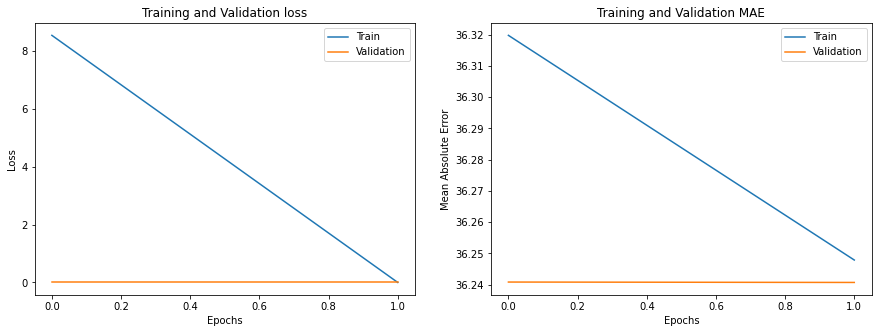

In [30]:
plot_history(history.history)

In [31]:
df_pred = model_predictions(lstm_model, X_test, y_test)
print("Distance(m): [{}, {}]".format(min(df_pred['distance(m)']),
                                     max(df_pred['distance(m)'])))
df_pred

76/76 [==============================] - 2s 23ms/step
Distance(m): [3.3440720267695405, 1009.2371683306674]


,latitude(pred),longitude(pred),heading(pred),speed(m/s)(pred),acceleration(m/s²)(pred),latitude,longitude,heading,speed(m/s),acceleration(m/s²),distance(m)
0,41.395762,2.150126,0.336385,0.701664,-0.150996,41.394340,2.151350,72.348077,0.000000,0.000000,188.231857
1,41.395822,2.149681,0.224379,-0.355860,-1.945923,41.394340,2.151350,72.348077,0.000000,0.000000,215.722657
2,41.395831,2.149670,-0.426811,-0.111546,-0.484320,41.394340,2.151350,72.348077,0.000000,0.000000,217.133494
3,41.395619,2.149229,-0.476481,-1.945724,1.356600,41.394340,2.151350,72.348077,0.000000,0.000000,226.991705
4,41.395690,2.149385,1.139910,0.159241,-1.169787,41.394340,2.151350,72.348077,0.000000,0.000000,222.287446
...,...,...,...,...,...,...,...,...,...,...,...
12005,41.397337,2.149988,0.336289,0.702307,-0.151519,41.400268,2.151179,44.652289,7.775367,0.289365,340.722704
12006,41.397458,2.149410,0.224095,-0.356460,-1.946196,41.400317,2.151234,39.488036,7.149873,-0.625495,352.463940
12007,41.397509,2.149396,-0.426887,-0.111224,-0.484893,41.400383,2.151277,23.947936,8.208109,1.058236,355.984991
12008,41.396754,2.148862,-0.476268,-1.946060,1.356194,41.400452,2.151264,348.255669,8.071555,-0.136553,457.475509


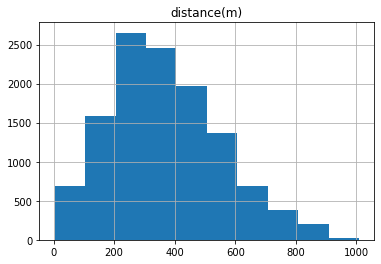

In [32]:
df_pred.hist('distance(m)')
plt.show()

In [33]:
n_rows = df_pred.shape[0]
list_1seg, list_2seg, list_3seg, list_4seg, list_5seg = \
  [False]*n_rows, [False]*n_rows, [False]*n_rows, [False]*n_rows, [False]*n_rows

for i in range(n_rows):
    if i%5 == 0:
        list_1seg[i] = True
    elif i%5 == 1:
        list_2seg[i] = True
    elif i%5 == 2:
        list_3seg[i] = True
    elif i%5 == 3:
        list_4seg[i] = True
    elif i%5 == 4:
        list_5seg[i] = True

df_pred_1seg = df_pred.iloc[list_1seg, :]
df_pred_2seg = df_pred.iloc[list_2seg, :]
df_pred_3seg = df_pred.iloc[list_3seg, :]
df_pred_4seg = df_pred.iloc[list_4seg, :]
df_pred_5seg = df_pred.iloc[list_5seg, :]

In [34]:
print("Segundo 1: [{}, {}]".format(min(df_pred_1seg['distance(m)']),
                                   max(df_pred_1seg['distance(m)'])))
print("Segundo 2: [{}, {}]".format(min(df_pred_2seg['distance(m)']),
                                   max(df_pred_2seg['distance(m)'])))
print("Segundo 3: [{}, {}]".format(min(df_pred_3seg['distance(m)']),
                                   max(df_pred_3seg['distance(m)'])))
print("Segundo 4: [{}, {}]".format(min(df_pred_4seg['distance(m)']),
                                   max(df_pred_4seg['distance(m)'])))
print("Segundo 5: [{}, {}]".format(min(df_pred_5seg['distance(m)']),
                                   max(df_pred_5seg['distance(m)'])))

Segundo 1: [13.165897992956795, 1009.2371683306674]
Segundo 2: [12.453915998832356, 982.2388634723749]
Segundo 3: [10.527886941067017, 978.8782800314364]
Segundo 4: [12.213315854220236, 998.123664835608]
Segundo 5: [3.3440720267695405, 1004.5910950178451]


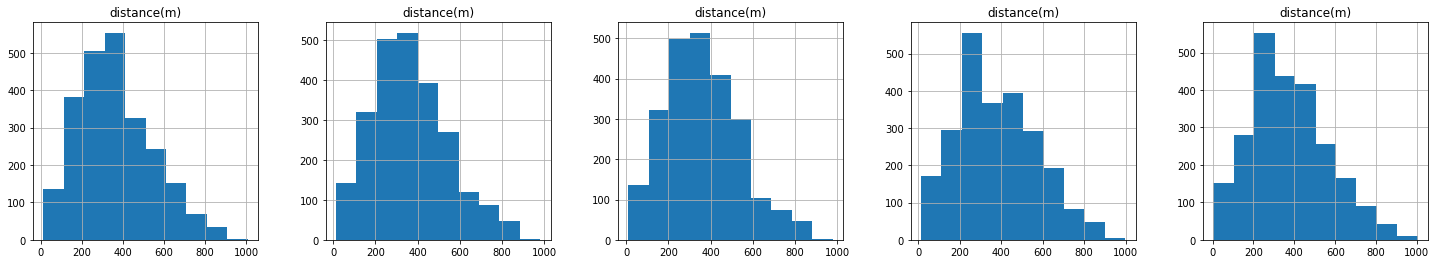

In [35]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(25,4))
df_pred_1seg.hist('distance(m)', ax=ax[0])
df_pred_2seg.hist('distance(m)', ax=ax[1])
df_pred_3seg.hist('distance(m)', ax=ax[2])
df_pred_4seg.hist('distance(m)', ax=ax[3])
df_pred_5seg.hist('distance(m)', ax=ax[4])
plt.show()

In [36]:
df_pred_1seg.describe()

,latitude(pred),longitude(pred),heading(pred),speed(m/s)(pred),acceleration(m/s²)(pred),latitude,longitude,heading,speed(m/s),acceleration(m/s²),distance(m)
count,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000
mean,41.396166,2.149841,0.336430,0.701974,-0.151391,41.396994,2.149619,184.171392,5.743007,0.164075,363.587174
std,0.000948,0.000277,0.000115,0.000533,0.000414,0.002307,0.003671,98.232361,5.102721,1.308594,180.601949
min,41.393185,2.148846,0.335992,0.700879,-0.152440,41.390906,2.139125,0.939814,0.000000,-10.000000,13.165898
25%,41.395585,2.149727,0.336353,0.701521,-0.151717,41.395245,2.147242,101.919406,0.172846,-0.104516,229.402266
50%,41.396149,2.149925,0.336392,0.701978,-0.151321,41.396960,2.149929,155.247244,4.966377,0.000000,343.910264
75%,41.396965,2.150057,0.336471,0.702417,-0.151014,41.398961,2.151950,256.275266,10.340684,0.774525,470.195709
max,41.397577,2.150207,0.336796,0.703013,-0.150833,41.401814,2.158624,357.404922,16.640354,5.988961,1009.237168


In [37]:
df_pred_2seg.describe()

,latitude(pred),longitude(pred),heading(pred),speed(m/s)(pred),acceleration(m/s²)(pred),latitude,longitude,heading,speed(m/s),acceleration(m/s²),distance(m)
count,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000
mean,41.396193,2.149441,0.224096,-0.356125,-1.946133,41.396996,2.149621,184.160835,5.890808,0.147801,363.773473
std,0.001013,0.000310,0.000276,0.000478,0.000146,0.002308,0.003673,98.298534,4.947635,1.448525,177.591728
min,41.392937,2.148485,0.223250,-0.356953,-1.946350,41.390873,2.139078,0.939814,0.000000,-10.000000,12.453916
25%,41.395663,2.149243,0.223920,-0.356539,-1.946265,41.395234,2.147314,101.844412,0.968818,-0.154634,239.413653
50%,41.396227,2.149561,0.224198,-0.356167,-1.946159,41.396960,2.149913,155.264593,5.239587,0.030756,346.774300
75%,41.397011,2.149710,0.224312,-0.355733,-1.946017,41.398949,2.151951,256.443895,9.990617,0.898349,474.866089
max,41.397639,2.149735,0.224485,-0.355062,-1.945529,41.401864,2.158743,358.402101,16.602367,5.993102,982.238863


In [38]:
df_pred_3seg.describe()

,latitude(pred),longitude(pred),heading(pred),speed(m/s)(pred),acceleration(m/s²)(pred),latitude,longitude,heading,speed(m/s),acceleration(m/s²),distance(m)
count,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000
mean,41.396354,2.149395,-0.426967,-0.111518,-0.484577,41.396996,2.149623,184.186244,6.081826,0.191018,360.887616
std,0.000961,0.000352,0.000187,0.000273,0.000468,0.002308,0.003675,98.566199,4.650839,1.636780,174.646408
min,41.393330,2.148247,-0.427650,-0.112330,-0.485426,41.390836,2.139009,0.373142,0.000000,-9.706740,10.527887
25%,41.395826,2.149188,-0.427036,-0.111680,-0.484975,41.395221,2.147382,103.263678,2.096294,-0.201319,236.397091
50%,41.396452,2.149559,-0.426893,-0.111395,-0.484604,41.396951,2.149961,155.606261,5.454008,0.089373,344.136069
75%,41.397151,2.149663,-0.426825,-0.111318,-0.484188,41.398932,2.151952,262.182490,9.341440,1.054450,474.856158
max,41.397720,2.149722,-0.426639,-0.111063,-0.483563,41.401915,2.158883,359.323010,16.546956,5.998546,978.878280


In [39]:
df_pred_4seg.describe()

,latitude(pred),longitude(pred),heading(pred),speed(m/s)(pred),acceleration(m/s²)(pred),latitude,longitude,heading,speed(m/s),acceleration(m/s²),distance(m)
count,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000
mean,41.395648,2.149078,-0.476521,-1.946074,1.356396,41.396997,2.149625,183.173735,6.130936,0.049110,378.402183
std,0.000895,0.000395,0.000196,0.000281,0.000313,0.002309,0.003675,99.410339,4.357840,1.918388,192.537156
min,41.393016,2.148184,-0.477166,-1.946896,1.355815,41.390802,2.138863,2.280386,0.000000,-10.000000,12.213316
25%,41.395047,2.148772,-0.476582,-1.946258,1.356125,41.395206,2.147430,94.463904,2.726005,-0.410908,241.556019
50%,41.395750,2.149079,-0.476476,-1.945985,1.356386,41.396931,2.150051,160.120137,5.748746,0.085084,345.863295
75%,41.396419,2.149416,-0.476379,-1.945885,1.356651,41.398903,2.151970,268.070273,8.739849,1.113957,509.906562
max,41.397057,2.149813,-0.476228,-1.945399,1.357053,41.401967,2.158981,359.017348,16.626126,5.996870,998.123665


In [40]:
df_pred_5seg.describe()

,latitude(pred),longitude(pred),heading(pred),speed(m/s)(pred),acceleration(m/s²)(pred),latitude,longitude,heading,speed(m/s),acceleration(m/s²),distance(m)
count,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000
mean,41.395800,2.149294,1.140268,0.159191,-1.169622,41.396997,2.149628,176.707990,6.117309,0.105156,373.586259
std,0.000985,0.000272,0.000251,0.000169,0.000122,0.002309,0.003675,100.425471,4.092248,1.903228,189.546086
min,41.392729,2.148843,1.139334,0.158752,-1.170156,41.390767,2.138725,0.598478,0.000000,-10.000000,3.344072
25%,41.395227,2.149065,1.140120,0.159083,-1.169677,41.395191,2.147420,74.637179,3.188963,-0.242367,243.154269
50%,41.395795,2.149249,1.140254,0.159248,-1.169624,41.396900,2.150056,147.086299,6.220898,0.103251,355.548462
75%,41.396623,2.149511,1.140472,0.159330,-1.169544,41.398873,2.151995,261.391452,8.441894,1.059701,489.791438
max,41.397316,2.149927,1.140992,0.159703,-1.169325,41.402028,2.159084,359.352131,16.601876,5.982253,1004.591095


In [ ]:
# Load fitted model
MODELS_FOLDER =  './'
MODEL_FOLDER = os.path.join(MODELS_FOLDER, "simple_v2", "PINN_LSTM_32units")
MODEL_FILE = os.path.join(MODEL_FOLDER, "model_saved.hdf5")
model = tf.keras.models.load_model(MODEL_FILE, compile=False) #https://stackoverflow.com/questions/48373845/loading-model-with-custom-loss-keras

# Get test metrics
METRICS_FILE = os.path.join(MODEL_FOLDER, "metrics.txt")
get_metrics(model, X_test, df, vehicle_ids, df_col, df_nocol, df_dim, METRICS_FILE)

coinciden y colisionan: 2120
0
100
200
300
400
500
600
700
800
900
1000
1100
coinciden pero no colisionan: 2120
0
100
200
300
400
500
600
700
800
900
1000


In [42]:
def make_gru_model(units, in_steps, out_steps, in_features, out_features):
    gru_model = Sequential()

    # Shape [batch, time, in_features] => [batch, gru_units].
    gru_model.add(GRU(units, input_shape=(in_steps, in_features)))

    # Shape => [batch, out_steps*out_features].
    gru_model.add(Dense(out_steps*out_features))

    # Shape => [batch, out_steps, out_features].
    gru_model.add(Reshape([out_steps, out_features]))

    gru_model.summary()

    return gru_model

In [43]:
# Create model folder
MODEL_FOLDER = os.path.join(MODELS_FOLDER, "simple_v2", "PINN_GRU_32units")
os.makedirs(MODEL_FOLDER, exist_ok=True)

# Model parameters
GRU_UNITS=32

# Create, compile and fit model
gru_model = make_gru_model(GRU_UNITS, INPUT_WIDTH, OUTPUT_WIDTH,
                             len(INPUT_COL), len(OUTPUT_COL))
history = compile_and_fit(gru_model, X_train, y_train, X_val, y_val,
                          MODEL_FOLDER, epochs=EPOCHS, batch_size=BATCH_SIZE,
                          patience=PATIENCE, reduce_lr=REDUCELR)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 32)                3744      
                                                                 
 dense_2 (Dense)             (None, 25)                825       
                                                                 
 reshape_2 (Reshape)         (None, 5, 5)              0         
                                                                 
Total params: 4,569
Trainable params: 4,569
Non-trainable params: 0
_________________________________________________________________
X_train.shape: (6005877, 20, 5)
y_train.shape: (6005877, 5, 5)
Epoch 1/2
93842/93842 [==============================] - 10905s 116ms/step - loss: 8.3384 - mean_absolute_error: 36.0870 - val_loss: 1.6067e-05 - val_mean_absolute_error: 36.0104 - lr: 0.0010
Epoch 2/2
93842/93842 [==============================] - 1080

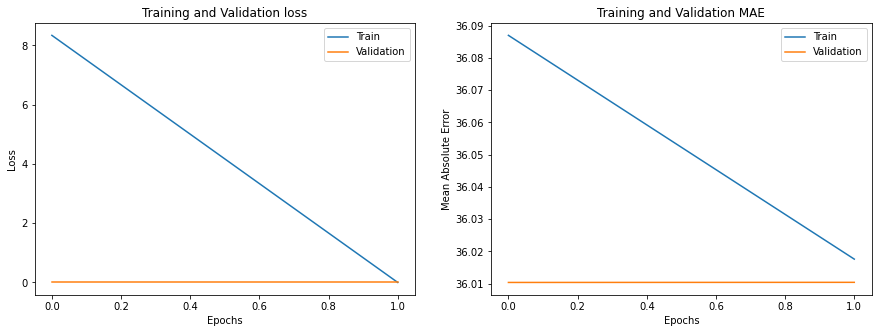

In [44]:
plot_history(history.history)

In [45]:
df_pred = model_predictions(lstm_model, X_test, y_test)
print("Distance(m): [{}, {}]".format(min(df_pred['distance(m)']),
                                     max(df_pred['distance(m)'])))
df_pred

76/76 [==============================] - 2s 29ms/step
Distance(m): [3.3440720267695405, 1009.2371683306674]


,latitude(pred),longitude(pred),heading(pred),speed(m/s)(pred),acceleration(m/s²)(pred),latitude,longitude,heading,speed(m/s),acceleration(m/s²),distance(m)
0,41.395762,2.150126,0.336385,0.701664,-0.150996,41.394340,2.151350,72.348077,0.000000,0.000000,188.231857
1,41.395822,2.149681,0.224379,-0.355860,-1.945923,41.394340,2.151350,72.348077,0.000000,0.000000,215.722657
2,41.395831,2.149670,-0.426811,-0.111546,-0.484320,41.394340,2.151350,72.348077,0.000000,0.000000,217.133494
3,41.395619,2.149229,-0.476481,-1.945724,1.356600,41.394340,2.151350,72.348077,0.000000,0.000000,226.991705
4,41.395690,2.149385,1.139910,0.159241,-1.169787,41.394340,2.151350,72.348077,0.000000,0.000000,222.287446
...,...,...,...,...,...,...,...,...,...,...,...
12005,41.397337,2.149988,0.336289,0.702307,-0.151519,41.400268,2.151179,44.652289,7.775367,0.289365,340.722704
12006,41.397458,2.149410,0.224095,-0.356460,-1.946196,41.400317,2.151234,39.488036,7.149873,-0.625495,352.463940
12007,41.397509,2.149396,-0.426887,-0.111224,-0.484893,41.400383,2.151277,23.947936,8.208109,1.058236,355.984991
12008,41.396754,2.148862,-0.476268,-1.946060,1.356194,41.400452,2.151264,348.255669,8.071555,-0.136553,457.475509


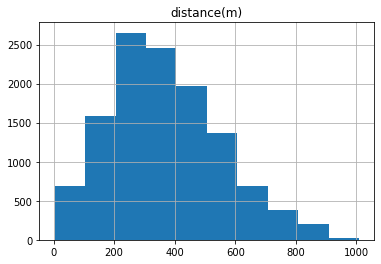

In [46]:
df_pred.hist('distance(m)')
plt.show()

In [47]:
n_rows = df_pred.shape[0]
list_1seg, list_2seg, list_3seg, list_4seg, list_5seg = \
  [False]*n_rows, [False]*n_rows, [False]*n_rows, [False]*n_rows, [False]*n_rows

for i in range(n_rows):
    if i%5 == 0:
        list_1seg[i] = True
    elif i%5 == 1:
        list_2seg[i] = True
    elif i%5 == 2:
        list_3seg[i] = True
    elif i%5 == 3:
        list_4seg[i] = True
    elif i%5 == 4:
        list_5seg[i] = True

df_pred_1seg = df_pred.iloc[list_1seg, :]
df_pred_2seg = df_pred.iloc[list_2seg, :]
df_pred_3seg = df_pred.iloc[list_3seg, :]
df_pred_4seg = df_pred.iloc[list_4seg, :]
df_pred_5seg = df_pred.iloc[list_5seg, :]

In [48]:
print("Segundo 1: [{}, {}]".format(min(df_pred_1seg['distance(m)']),
                                   max(df_pred_1seg['distance(m)'])))
print("Segundo 2: [{}, {}]".format(min(df_pred_2seg['distance(m)']),
                                   max(df_pred_2seg['distance(m)'])))
print("Segundo 3: [{}, {}]".format(min(df_pred_3seg['distance(m)']),
                                   max(df_pred_3seg['distance(m)'])))
print("Segundo 4: [{}, {}]".format(min(df_pred_4seg['distance(m)']),
                                   max(df_pred_4seg['distance(m)'])))
print("Segundo 5: [{}, {}]".format(min(df_pred_5seg['distance(m)']),
                                   max(df_pred_5seg['distance(m)'])))

Segundo 1: [13.165897992956795, 1009.2371683306674]
Segundo 2: [12.453915998832356, 982.2388634723749]
Segundo 3: [10.527886941067017, 978.8782800314364]
Segundo 4: [12.213315854220236, 998.123664835608]
Segundo 5: [3.3440720267695405, 1004.5910950178451]


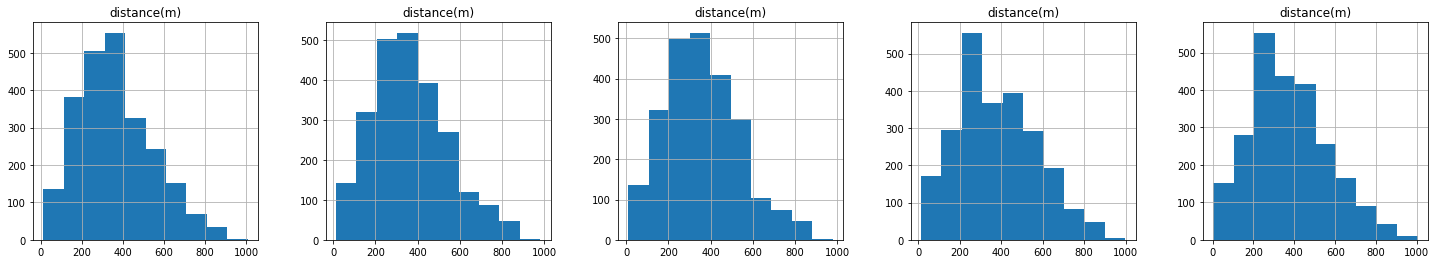

In [49]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(25,4))
df_pred_1seg.hist('distance(m)', ax=ax[0])
df_pred_2seg.hist('distance(m)', ax=ax[1])
df_pred_3seg.hist('distance(m)', ax=ax[2])
df_pred_4seg.hist('distance(m)', ax=ax[3])
df_pred_5seg.hist('distance(m)', ax=ax[4])
plt.show()

In [50]:
df_pred_1seg.describe()

,latitude(pred),longitude(pred),heading(pred),speed(m/s)(pred),acceleration(m/s²)(pred),latitude,longitude,heading,speed(m/s),acceleration(m/s²),distance(m)
count,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000
mean,41.396166,2.149841,0.336430,0.701974,-0.151391,41.396994,2.149619,184.171392,5.743007,0.164075,363.587174
std,0.000948,0.000277,0.000115,0.000533,0.000414,0.002307,0.003671,98.232361,5.102721,1.308594,180.601949
min,41.393185,2.148846,0.335992,0.700879,-0.152440,41.390906,2.139125,0.939814,0.000000,-10.000000,13.165898
25%,41.395585,2.149727,0.336353,0.701521,-0.151717,41.395245,2.147242,101.919406,0.172846,-0.104516,229.402266
50%,41.396149,2.149925,0.336392,0.701978,-0.151321,41.396960,2.149929,155.247244,4.966377,0.000000,343.910264
75%,41.396965,2.150057,0.336471,0.702417,-0.151014,41.398961,2.151950,256.275266,10.340684,0.774525,470.195709
max,41.397577,2.150207,0.336796,0.703013,-0.150833,41.401814,2.158624,357.404922,16.640354,5.988961,1009.237168


In [51]:
df_pred_2seg.describe()

,latitude(pred),longitude(pred),heading(pred),speed(m/s)(pred),acceleration(m/s²)(pred),latitude,longitude,heading,speed(m/s),acceleration(m/s²),distance(m)
count,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000
mean,41.396193,2.149441,0.224096,-0.356125,-1.946133,41.396996,2.149621,184.160835,5.890808,0.147801,363.773473
std,0.001013,0.000310,0.000276,0.000478,0.000146,0.002308,0.003673,98.298534,4.947635,1.448525,177.591728
min,41.392937,2.148485,0.223250,-0.356953,-1.946350,41.390873,2.139078,0.939814,0.000000,-10.000000,12.453916
25%,41.395663,2.149243,0.223920,-0.356539,-1.946265,41.395234,2.147314,101.844412,0.968818,-0.154634,239.413653
50%,41.396227,2.149561,0.224198,-0.356167,-1.946159,41.396960,2.149913,155.264593,5.239587,0.030756,346.774300
75%,41.397011,2.149710,0.224312,-0.355733,-1.946017,41.398949,2.151951,256.443895,9.990617,0.898349,474.866089
max,41.397639,2.149735,0.224485,-0.355062,-1.945529,41.401864,2.158743,358.402101,16.602367,5.993102,982.238863


In [52]:
df_pred_3seg.describe()

,latitude(pred),longitude(pred),heading(pred),speed(m/s)(pred),acceleration(m/s²)(pred),latitude,longitude,heading,speed(m/s),acceleration(m/s²),distance(m)
count,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000
mean,41.396354,2.149395,-0.426967,-0.111518,-0.484577,41.396996,2.149623,184.186244,6.081826,0.191018,360.887616
std,0.000961,0.000352,0.000187,0.000273,0.000468,0.002308,0.003675,98.566199,4.650839,1.636780,174.646408
min,41.393330,2.148247,-0.427650,-0.112330,-0.485426,41.390836,2.139009,0.373142,0.000000,-9.706740,10.527887
25%,41.395826,2.149188,-0.427036,-0.111680,-0.484975,41.395221,2.147382,103.263678,2.096294,-0.201319,236.397091
50%,41.396452,2.149559,-0.426893,-0.111395,-0.484604,41.396951,2.149961,155.606261,5.454008,0.089373,344.136069
75%,41.397151,2.149663,-0.426825,-0.111318,-0.484188,41.398932,2.151952,262.182490,9.341440,1.054450,474.856158
max,41.397720,2.149722,-0.426639,-0.111063,-0.483563,41.401915,2.158883,359.323010,16.546956,5.998546,978.878280


In [53]:
df_pred_4seg.describe()

,latitude(pred),longitude(pred),heading(pred),speed(m/s)(pred),acceleration(m/s²)(pred),latitude,longitude,heading,speed(m/s),acceleration(m/s²),distance(m)
count,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000
mean,41.395648,2.149078,-0.476521,-1.946074,1.356396,41.396997,2.149625,183.173735,6.130936,0.049110,378.402183
std,0.000895,0.000395,0.000196,0.000281,0.000313,0.002309,0.003675,99.410339,4.357840,1.918388,192.537156
min,41.393016,2.148184,-0.477166,-1.946896,1.355815,41.390802,2.138863,2.280386,0.000000,-10.000000,12.213316
25%,41.395047,2.148772,-0.476582,-1.946258,1.356125,41.395206,2.147430,94.463904,2.726005,-0.410908,241.556019
50%,41.395750,2.149079,-0.476476,-1.945985,1.356386,41.396931,2.150051,160.120137,5.748746,0.085084,345.863295
75%,41.396419,2.149416,-0.476379,-1.945885,1.356651,41.398903,2.151970,268.070273,8.739849,1.113957,509.906562
max,41.397057,2.149813,-0.476228,-1.945399,1.357053,41.401967,2.158981,359.017348,16.626126,5.996870,998.123665


In [54]:
df_pred_5seg.describe()

,latitude(pred),longitude(pred),heading(pred),speed(m/s)(pred),acceleration(m/s²)(pred),latitude,longitude,heading,speed(m/s),acceleration(m/s²),distance(m)
count,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000
mean,41.395800,2.149294,1.140268,0.159191,-1.169622,41.396997,2.149628,176.707990,6.117309,0.105156,373.586259
std,0.000985,0.000272,0.000251,0.000169,0.000122,0.002309,0.003675,100.425471,4.092248,1.903228,189.546086
min,41.392729,2.148843,1.139334,0.158752,-1.170156,41.390767,2.138725,0.598478,0.000000,-10.000000,3.344072
25%,41.395227,2.149065,1.140120,0.159083,-1.169677,41.395191,2.147420,74.637179,3.188963,-0.242367,243.154269
50%,41.395795,2.149249,1.140254,0.159248,-1.169624,41.396900,2.150056,147.086299,6.220898,0.103251,355.548462
75%,41.396623,2.149511,1.140472,0.159330,-1.169544,41.398873,2.151995,261.391452,8.441894,1.059701,489.791438
max,41.397316,2.149927,1.140992,0.159703,-1.169325,41.402028,2.159084,359.352131,16.601876,5.982253,1004.591095


In [ ]:
# Load fitted model
MODEL_FOLDER = os.path.join(MODELS_FOLDER, "simple_v2", "PINN_GRU_32units")
MODEL_FILE = os.path.join(MODEL_FOLDER, "model_saved.hdf5")
model = tf.keras.models.load_model(MODEL_FILE, compile=False) #https://stackoverflow.com/questions/48373845/loading-model-with-custom-loss-keras

# Get test metrics
METRICS_FILE = os.path.join(MODEL_FOLDER, "metrics.txt")
get_metrics(model, X_test, df, vehicle_ids, df_col, df_nocol, df_dim, METRICS_FILE)

In [56]:
# Create model folder
MODEL_FOLDER = os.path.join(MODELS_FOLDER, "simple_v2", "PINN_GRU_64units")
os.makedirs(MODEL_FOLDER, exist_ok=True)

# Model parameters
GRU_UNITS=64

# Create, compile and fit model
gru_model = make_gru_model(GRU_UNITS, INPUT_WIDTH, OUTPUT_WIDTH,
                             len(INPUT_COL), len(OUTPUT_COL))
history = compile_and_fit(gru_model, X_train, y_train, X_val, y_val,
                          MODEL_FOLDER, epochs=EPOCHS, batch_size=BATCH_SIZE,
                          patience=PATIENCE, reduce_lr=REDUCELR)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 64)                13632     
                                                                 
 dense_3 (Dense)             (None, 25)                1625      
                                                                 
 reshape_3 (Reshape)         (None, 5, 5)              0         
                                                                 
Total params: 15,257
Trainable params: 15,257
Non-trainable params: 0
_________________________________________________________________
X_train.shape: (6005877, 20, 5)
y_train.shape: (6005877, 5, 5)
Epoch 1/2
93842/93842 [==============================] - 22186s 236ms/step - loss: 4.0906 - mean_absolute_error: 36.2516 - val_loss: 2.1394e-05 - val_mean_absolute_error: 36.2102 - lr: 0.0010
Epoch 2/2
93842/93842 [==============================] - 25

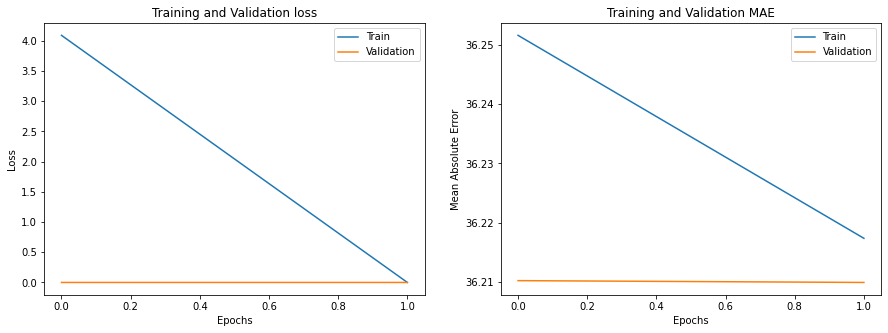

In [57]:
plot_history(history.history)

In [58]:
df_pred = model_predictions(lstm_model, X_test, y_test)
print("Distance(m): [{}, {}]".format(min(df_pred['distance(m)']),
                                     max(df_pred['distance(m)'])))
df_pred

76/76 [==============================] - 3s 41ms/step
Distance(m): [3.3440720267695405, 1009.2371683306674]


,latitude(pred),longitude(pred),heading(pred),speed(m/s)(pred),acceleration(m/s²)(pred),latitude,longitude,heading,speed(m/s),acceleration(m/s²),distance(m)
0,41.395762,2.150126,0.336385,0.701664,-0.150996,41.394340,2.151350,72.348077,0.000000,0.000000,188.231857
1,41.395822,2.149681,0.224379,-0.355860,-1.945923,41.394340,2.151350,72.348077,0.000000,0.000000,215.722657
2,41.395831,2.149670,-0.426811,-0.111546,-0.484320,41.394340,2.151350,72.348077,0.000000,0.000000,217.133494
3,41.395619,2.149229,-0.476481,-1.945724,1.356600,41.394340,2.151350,72.348077,0.000000,0.000000,226.991705
4,41.395690,2.149385,1.139910,0.159241,-1.169787,41.394340,2.151350,72.348077,0.000000,0.000000,222.287446
...,...,...,...,...,...,...,...,...,...,...,...
12005,41.397337,2.149988,0.336289,0.702307,-0.151519,41.400268,2.151179,44.652289,7.775367,0.289365,340.722704
12006,41.397458,2.149410,0.224095,-0.356460,-1.946196,41.400317,2.151234,39.488036,7.149873,-0.625495,352.463940
12007,41.397509,2.149396,-0.426887,-0.111224,-0.484893,41.400383,2.151277,23.947936,8.208109,1.058236,355.984991
12008,41.396754,2.148862,-0.476268,-1.946060,1.356194,41.400452,2.151264,348.255669,8.071555,-0.136553,457.475509


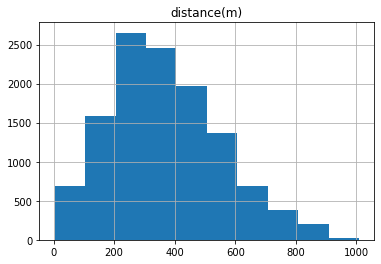

In [59]:
df_pred.hist('distance(m)')
plt.show()

In [60]:
n_rows = df_pred.shape[0]
list_1seg, list_2seg, list_3seg, list_4seg, list_5seg = \
  [False]*n_rows, [False]*n_rows, [False]*n_rows, [False]*n_rows, [False]*n_rows

for i in range(n_rows):
    if i%5 == 0:
        list_1seg[i] = True
    elif i%5 == 1:
        list_2seg[i] = True
    elif i%5 == 2:
        list_3seg[i] = True
    elif i%5 == 3:
        list_4seg[i] = True
    elif i%5 == 4:
        list_5seg[i] = True

df_pred_1seg = df_pred.iloc[list_1seg, :]
df_pred_2seg = df_pred.iloc[list_2seg, :]
df_pred_3seg = df_pred.iloc[list_3seg, :]
df_pred_4seg = df_pred.iloc[list_4seg, :]
df_pred_5seg = df_pred.iloc[list_5seg, :]

In [61]:
print("Segundo 1: [{}, {}]".format(min(df_pred_1seg['distance(m)']),
                                   max(df_pred_1seg['distance(m)'])))
print("Segundo 2: [{}, {}]".format(min(df_pred_2seg['distance(m)']),
                                   max(df_pred_2seg['distance(m)'])))
print("Segundo 3: [{}, {}]".format(min(df_pred_3seg['distance(m)']),
                                   max(df_pred_3seg['distance(m)'])))
print("Segundo 4: [{}, {}]".format(min(df_pred_4seg['distance(m)']),
                                   max(df_pred_4seg['distance(m)'])))
print("Segundo 5: [{}, {}]".format(min(df_pred_5seg['distance(m)']),
                                   max(df_pred_5seg['distance(m)'])))

Segundo 1: [13.165897992956795, 1009.2371683306674]
Segundo 2: [12.453915998832356, 982.2388634723749]
Segundo 3: [10.527886941067017, 978.8782800314364]
Segundo 4: [12.213315854220236, 998.123664835608]
Segundo 5: [3.3440720267695405, 1004.5910950178451]


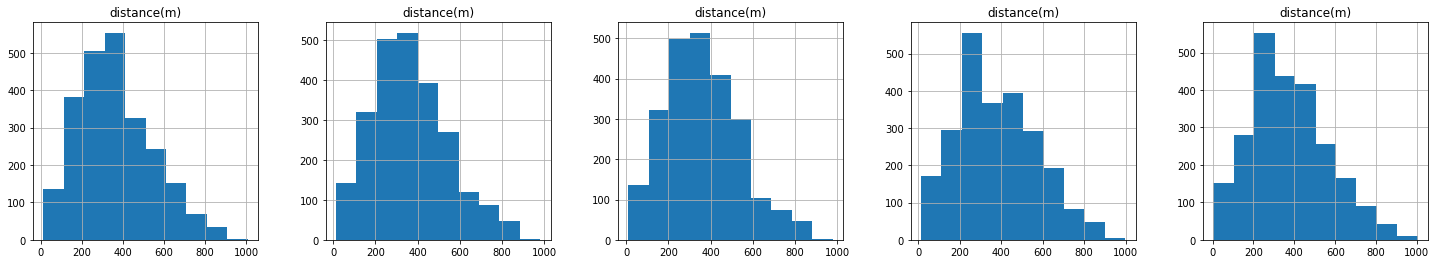

In [62]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(25,4))
df_pred_1seg.hist('distance(m)', ax=ax[0])
df_pred_2seg.hist('distance(m)', ax=ax[1])
df_pred_3seg.hist('distance(m)', ax=ax[2])
df_pred_4seg.hist('distance(m)', ax=ax[3])
df_pred_5seg.hist('distance(m)', ax=ax[4])
plt.show()

In [63]:
df_pred_1seg.describe()

,latitude(pred),longitude(pred),heading(pred),speed(m/s)(pred),acceleration(m/s²)(pred),latitude,longitude,heading,speed(m/s),acceleration(m/s²),distance(m)
count,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000
mean,41.396166,2.149841,0.336430,0.701974,-0.151391,41.396994,2.149619,184.171392,5.743007,0.164075,363.587174
std,0.000948,0.000277,0.000115,0.000533,0.000414,0.002307,0.003671,98.232361,5.102721,1.308594,180.601949
min,41.393185,2.148846,0.335992,0.700879,-0.152440,41.390906,2.139125,0.939814,0.000000,-10.000000,13.165898
25%,41.395585,2.149727,0.336353,0.701521,-0.151717,41.395245,2.147242,101.919406,0.172846,-0.104516,229.402266
50%,41.396149,2.149925,0.336392,0.701978,-0.151321,41.396960,2.149929,155.247244,4.966377,0.000000,343.910264
75%,41.396965,2.150057,0.336471,0.702417,-0.151014,41.398961,2.151950,256.275266,10.340684,0.774525,470.195709
max,41.397577,2.150207,0.336796,0.703013,-0.150833,41.401814,2.158624,357.404922,16.640354,5.988961,1009.237168


In [64]:
df_pred_2seg.describe()

,latitude(pred),longitude(pred),heading(pred),speed(m/s)(pred),acceleration(m/s²)(pred),latitude,longitude,heading,speed(m/s),acceleration(m/s²),distance(m)
count,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000
mean,41.396166,2.149841,0.336430,0.701974,-0.151391,41.396994,2.149619,184.171392,5.743007,0.164075,363.587174
std,0.000948,0.000277,0.000115,0.000533,0.000414,0.002307,0.003671,98.232361,5.102721,1.308594,180.601949
min,41.393185,2.148846,0.335992,0.700879,-0.152440,41.390906,2.139125,0.939814,0.000000,-10.000000,13.165898
25%,41.395585,2.149727,0.336353,0.701521,-0.151717,41.395245,2.147242,101.919406,0.172846,-0.104516,229.402266
50%,41.396149,2.149925,0.336392,0.701978,-0.151321,41.396960,2.149929,155.247244,4.966377,0.000000,343.910264
75%,41.396965,2.150057,0.336471,0.702417,-0.151014,41.398961,2.151950,256.275266,10.340684,0.774525,470.195709
max,41.397577,2.150207,0.336796,0.703013,-0.150833,41.401814,2.158624,357.404922,16.640354,5.988961,1009.237168


In [65]:
df_pred_3seg.describe()

,latitude(pred),longitude(pred),heading(pred),speed(m/s)(pred),acceleration(m/s²)(pred),latitude,longitude,heading,speed(m/s),acceleration(m/s²),distance(m)
count,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000
mean,41.396166,2.149841,0.336430,0.701974,-0.151391,41.396994,2.149619,184.171392,5.743007,0.164075,363.587174
std,0.000948,0.000277,0.000115,0.000533,0.000414,0.002307,0.003671,98.232361,5.102721,1.308594,180.601949
min,41.393185,2.148846,0.335992,0.700879,-0.152440,41.390906,2.139125,0.939814,0.000000,-10.000000,13.165898
25%,41.395585,2.149727,0.336353,0.701521,-0.151717,41.395245,2.147242,101.919406,0.172846,-0.104516,229.402266
50%,41.396149,2.149925,0.336392,0.701978,-0.151321,41.396960,2.149929,155.247244,4.966377,0.000000,343.910264
75%,41.396965,2.150057,0.336471,0.702417,-0.151014,41.398961,2.151950,256.275266,10.340684,0.774525,470.195709
max,41.397577,2.150207,0.336796,0.703013,-0.150833,41.401814,2.158624,357.404922,16.640354,5.988961,1009.237168


In [66]:
df_pred_4seg.describe()

,latitude(pred),longitude(pred),heading(pred),speed(m/s)(pred),acceleration(m/s²)(pred),latitude,longitude,heading,speed(m/s),acceleration(m/s²),distance(m)
count,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000
mean,41.396166,2.149841,0.336430,0.701974,-0.151391,41.396994,2.149619,184.171392,5.743007,0.164075,363.587174
std,0.000948,0.000277,0.000115,0.000533,0.000414,0.002307,0.003671,98.232361,5.102721,1.308594,180.601949
min,41.393185,2.148846,0.335992,0.700879,-0.152440,41.390906,2.139125,0.939814,0.000000,-10.000000,13.165898
25%,41.395585,2.149727,0.336353,0.701521,-0.151717,41.395245,2.147242,101.919406,0.172846,-0.104516,229.402266
50%,41.396149,2.149925,0.336392,0.701978,-0.151321,41.396960,2.149929,155.247244,4.966377,0.000000,343.910264
75%,41.396965,2.150057,0.336471,0.702417,-0.151014,41.398961,2.151950,256.275266,10.340684,0.774525,470.195709
max,41.397577,2.150207,0.336796,0.703013,-0.150833,41.401814,2.158624,357.404922,16.640354,5.988961,1009.237168


In [67]:
df_pred_5seg.describe()

,latitude(pred),longitude(pred),heading(pred),speed(m/s)(pred),acceleration(m/s²)(pred),latitude,longitude,heading,speed(m/s),acceleration(m/s²),distance(m)
count,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000
mean,41.396166,2.149841,0.336430,0.701974,-0.151391,41.396994,2.149619,184.171392,5.743007,0.164075,363.587174
std,0.000948,0.000277,0.000115,0.000533,0.000414,0.002307,0.003671,98.232361,5.102721,1.308594,180.601949
min,41.393185,2.148846,0.335992,0.700879,-0.152440,41.390906,2.139125,0.939814,0.000000,-10.000000,13.165898
25%,41.395585,2.149727,0.336353,0.701521,-0.151717,41.395245,2.147242,101.919406,0.172846,-0.104516,229.402266
50%,41.396149,2.149925,0.336392,0.701978,-0.151321,41.396960,2.149929,155.247244,4.966377,0.000000,343.910264
75%,41.396965,2.150057,0.336471,0.702417,-0.151014,41.398961,2.151950,256.275266,10.340684,0.774525,470.195709
max,41.397577,2.150207,0.336796,0.703013,-0.150833,41.401814,2.158624,357.404922,16.640354,5.988961,1009.237168


In [ ]:
# Load fitted model
MODEL_FOLDER = os.path.join(MODELS_FOLDER, "simple_v2", "PINN_GRU_64units")
MODEL_FILE = os.path.join(MODEL_FOLDER, "model_saved.hdf5")
model = tf.keras.models.load_model(MODEL_FILE, compile=False) #https://stackoverflow.com/questions/48373845/loading-model-with-custom-loss-keras

# Get test metrics
METRICS_FILE = os.path.join(MODEL_FOLDER, "metrics.txt")
get_metrics(model, X_test, df, vehicle_ids, df_col, df_nocol, df_dim, METRICS_FILE)